In [1]:
# import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageDraw
from io import BytesIO
import imageio.v3 as iio

In [2]:
class Circle:
    def __init__(self, radius=1.0, center=(0.0, 0.0)):
        self.x, self.y = center
        self.radius = radius
    
    def set_center_xy(self, x, y):
        self.x = x
        self.y = y
        
    def shift_center_xy(self, vec):
        self.x += vec[0]
        self.y += vec[1]

    def get_radius(self):
        return self.radius
    
    def set_radius(self, radius):
        self.radius = radius
    
    def get_circumference(self):
        return self.radius * 2 * np.pi
    
    def get_diameter(self):
        return self.radius * 2
    
    def scale_radius(self, scale):
        self.radius *= scale
    
    def scale_circumference(self, scale):
        self.set_circumference(self.get_circumference() * scale)
    
    def get_area(self):
        return self.radius * self.radius * np.pi
    
    def set_area(self, area):
        self.radius = np.sqrt(area / np.pi)

    def set_circumference(self, circumference):
        self.radius = circumference / (2 * np.pi)
        
    def set_diameter(self, diameter):
        self.radius = diameter / 2
        
    def set_center_rtheta(self, r, theta):
        self.set_center_xy(r*np.cos(theta), r*np.sin(theta))
    
    def _gen_arc(self, start, stop, num):
        return np.linspace(start=start, stop=stop, num=num)
    
    def plot_arc_on_axes(self, ax, pi_start=0.0, pi_end=2*np.pi, n=100,*args, **kwargs):
        pi_start = pi_start
        pi_end = pi_end
        arc = self._gen_arc(pi_start, pi_end, n)
        x = self.x + self.radius * np.cos(arc)
        y = self.y + self.radius * np.sin(arc)
        ax.plot(x, y, **kwargs)
        

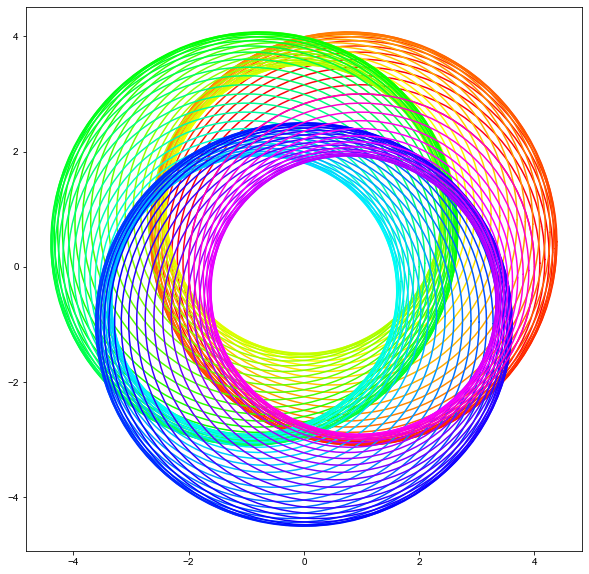

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
c = Circle()
edges = c._gen_arc(0, 2*np.pi, 99)

plt.style.use('seaborn-whitegrid')
for i, e in enumerate(edges):
    colors = plt.cm.gist_rainbow(np.linspace(0,1,len(edges)))
    r = 3 + 0.5*np.sin(3*e)
    c.set_center_rtheta(1.0, e)
    c.set_radius(r)
    c.plot_arc_on_axes(ax, color=colors[i])
plt.savefig("loops.png")
plt.savefig("loops.pdf")

In [4]:
# Rotating Constratined Poles
def deg_to_rad(angle):
  return (angle / 360.) * (np.pi * 2)

# TODO: express as a fraction.
def to_pi(rad):
  return f"{rad / np.pi :.2f} π"

In [5]:
class Pole():
  def __init__(self, length, angle, origin):
    """Angle in degrees, origin as a tuple."""
    self._length = length
    self._angle = angle
    self._origin = origin
    self._start, self._end = self.get_xy_coordinates()
    
  def update_origin(self, new_origin):
    self._origin = new_origin
    self._start, self.end = self.get_xy_coordinates()
    
  def update_angle(self, new_angle):
    self._angle = new_angle
    self._start, self.end = self.get_xy_coordinates()
  
  def get_xy_coordinates(self):
    x_start = self._origin[0]
    y_start = self._origin[1]
    
    x_end = x_start + self._length*np.cos(deg_to_rad(self._angle))
    y_end = y_start + self._length*np.sin(deg_to_rad(self._angle))
    
    return (x_start, y_start), (x_end, y_end)
    

(-2.2, 2.2)

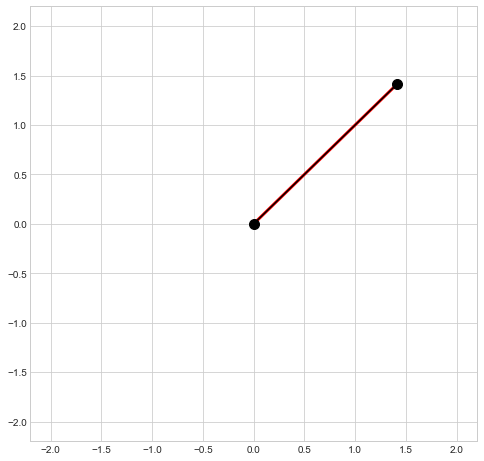

In [6]:
# plt.style.use('seaborn-whitegrid')
p = Pole(length=2, angle=45, origin=(0, 0))
start, end = p.get_xy_coordinates()
x, y = list(zip(start, end))

fig, ax = plt.subplots(figsize=(8, 8))

scatter_params = {
  'marker': 'o',
  'markersize': 10,
  'color':'black',
}

line_params = {
  'color':'red',
  'linewidth':3,
}
ax.plot(x, y, **line_params)
ax.plot(x, y, **scatter_params)

window_size = p._length * 1.1

ax.set_ylim(window_size * -1., window_size)
ax.set_xlim(window_size * -1., window_size)

In [7]:
# now, draw coupled poles. We couple using the origins.

p1 = Pole(length=1, angle=0,  origin=(0, 0))
p2 = Pole(length=0.5, angle=0, origin=p1.get_xy_coordinates()[1])
p3 = Pole(length=0.25, angle=0, origin=p2.get_xy_coordinates()[1])

poles = [p1, p2, p3]
# poles = [p1, p2]

In [43]:
def draw_poles(poles, pole_format="poles", return_pil=False, batch=False):
  window_size = 0
  fig, ax = plt.subplots(figsize=(8, 8))
  for p in poles:
    if pole_format == "poles":
      start, end = p.get_xy_coordinates()
      length = p._length
    elif pole_format == "coordinate_list":
      start, end = p
      length = np.sqrt((end[0]-start[0])**2 + (end[1]-start[1])**2)
    else:
      raise ValueError(f"Unsupported pole format: {type(poles)}")
      
    x, y = list(zip(start, end))

    scatter_params = {
      'marker': 'o',
      'markersize': 10,
      'color':'black',
      'linestyle': None,
      'linewidth':0
    }

    line_params = {
      'color':'red',
      'linewidth':3,
    }
    ax.plot(x, y, **line_params)
    ax.plot(x, y, **scatter_params)
    if batch:
      plt.close()
    window_size += length

  window_size*=1.1
  ax.set_ylim(window_size * -1., window_size)
  ax.set_xlim(window_size * -1., window_size)
  
  if return_pil:
    # f = BytesIO()
    # fig.savefig(f, format='png')
    
    # Get the image array
    canvas = fig.canvas
    canvas.draw()  # Draw the canvas, cache the renderer
    image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')  # (H * W * 3,)
    # NOTE: reversed converts (W, H) from get_width_height to (H, W)
    image = image_flat.reshape(*reversed(canvas.get_width_height()), 3)  # (H, W, 3)
    plt.close('all')
    return image
  return fig, ax

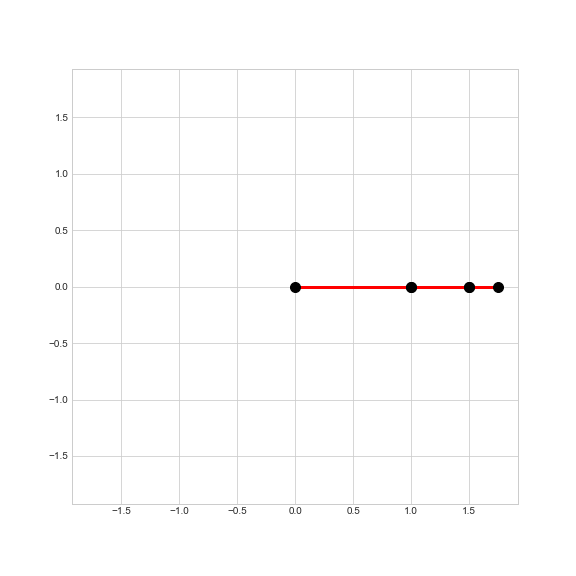

In [44]:
arr = draw_poles(poles, return_pil=True)
Image.fromarray(arr)

In [45]:
# Rotate the poles
p1 = Pole(length=1, angle=0,  origin=(0, 0))
p2 = Pole(length=0.5, angle=0, origin=p1.get_xy_coordinates()[1])
p3 = Pole(length=0.25, angle=0, origin=p2.get_xy_coordinates()[1])

poles = [p1, p2, p3]

p1_rotation_rate = 360. # degrees per second
p2_rotation_rate = -360. # degrees per second
p3_rotation_rate = 360. # degrees per second

fps = 50 # frames per second

p1_fps_rotation_rate = p1_rotation_rate / fps
p2_fps_rotation_rate = p2_rotation_rate / fps
p3_fps_rotation_rate = p3_rotation_rate / fps

clip_length = 1. # seconds

frames = []

frames.append(draw_poles([p1, p2, p3], pole_format="poles", return_pil=True))
  
for frame in range(int(fps * clip_length)):
  p1.update_angle(p1._angle + p1_fps_rotation_rate)
  p2.update_angle(p2._angle + p2_fps_rotation_rate)
  p3.update_angle(p3._angle + p3_fps_rotation_rate)
  p2.update_origin(p1.get_xy_coordinates()[1])
  p3.update_origin(p2.get_xy_coordinates()[1])
  frames.append(draw_poles([p1, p2, p3], pole_format="poles", return_pil=True, batch=True))
  
iio.imwrite("./test.gif", frames, format="GIF", fps=fps, loop=0)

In [46]:
def make_random_poles(n_poles, output_gif_name, duration_s):
  poles = []
  rotation_rates = []
  frames = []
  fps = 50
  
  for i in range(n_poles):
    if i == 0:
      poles.append(
         # Pole(length=np.random.rand(), angle=np.random.rand()*360, origin=(0,0)))
         Pole(length=1, angle=0, origin=(0,0)))
    else:
      poles.append(
        # Pole(length=np.random.rand()*10, angle=np.random.rand()*360, origin=poles[i-1].get_xy_coordinates()[1]))
        Pole(length=1, angle=1, origin=poles[i-1].get_xy_coordinates()[1]))
    rotation_rates.append(np.random.randint(-360, 360) / fps)


  frames.append(draw_poles(poles, pole_format="poles", return_pil=True))

  for frame in range(int(duration_s * fps)):
    for i, pole in enumerate(poles):
      current_angle = poles[i]._angle
      poles[i].update_angle(current_angle + rotation_rates[i])
      
      if i != 0:
        origin = poles[i-1].get_xy_coordinates()[1]
        poles[i].update_origin(origin)
        
    frames.append(draw_poles(poles, pole_format="poles", return_pil=True, batch=True))
  
  iio.imwrite(output_gif_name, frames, format="GIF", fps=fps, loop=0)

In [49]:
make_random_poles(n_poles=8, output_gif_name="random.gif", duration_s=30)